## Computational Physics 2 (WS23/24) – Project 1.2

Group: Emmy Noether

Students: Janik Rausch (628334), Camilo Tello Breuer (633291), Ida Wöstheinreich (628428)

In [1]:
using LinearAlgebra,Random,Printf

**Hamiltonian Module**

...

Periodic boundary conditions: $$\hat{\psi}\big((N_L-1)\textbf{e}_k\big)=\hat{\psi}(N_R\textbf{e}_k)\quad\text{and}\quad\hat{\psi}\big((N_R+1)\textbf{e}_k\big)=\hat{\psi}(N_L\textbf{e}_k)$$ for all $k\in\{1,\ldots,D\}$ with $N_L=-(N-1)/2$ and $N_R=(N-1)/2$ if $N$ is odd

In [59]:
function potential(μ::Number, ϵ::Number, n::Array)
    @assert(μ > 0, "μ = " * string(μ) * " must be positive")
    @assert(ϵ > 0, "ϵ = " * string(ϵ) * " must be positive")
    
    return @. μ/8 * (ϵ^2*dot(n,n) - 1)^2
end

function kinetic(μ::Number, ϵ::Number, ψ::Array) #with periodic boundary conditions
    @assert(μ > 0, "μ = " * string(μ) * " must be positive")
    @assert(ϵ > 0, "ϵ = " * string(ϵ) * " must be positive")
    
    D = ndims(ψ)
    N = size(ψ)[1]

    Δ = -2*D*ψ #last term of discretized Laplacian

    for k in 1:D
        Δ += selectdim(ψ, k, vcat(2:N,1:1)) + selectdim(ψ, k, vcat(N:N,1:N-1)) #remaining terms
    end
    
    return -1/(2*μ*ϵ^2) * Δ
end

function lattice(N::Int, D::Int) #construct array of lattice coordinates (with n = 0 in the center)
    @assert(N > 0, "N = " * string(N) * " must be positive")
    @assert(D > 0, "D = " * string(D) * " must be positive")
    
    if mod(N,2) == 0 n_1D = -(N-2)/2:N/2 end
    if mod(N,2) == 1 n_1D = -(N-1)/2:(N-1)/2 end

    if D == 1 return collect(n_1D) end
    
    n = collect(Base.product([n_1D for i in 1:D]...)) #Cartesian product
    
    return n
end

function Hamiltonian(μ::Number, ϵ::Number, ψ::Array)
    N = size(ψ)[1]
    D = ndims(ψ)
    
    Hψ = kinetic(μ, ϵ, ψ) + potential(μ, ϵ, lattice(N,D)) .* ψ
    
    return Hψ
end

Hamiltonian (generic function with 1 method)

**Eigenvector Module**

...

In [3]:
function power_method(vshape::Tuple{Vararg{Int}}, apply_A::Function, tol::Float64, maxiters::Int)
    @assert(tol > 0, "tol = " * string(tol) * " must be positive")
    @assert(maxiters > 0, "maxiters = " * string(maxiters) * " must be positive")
    
    v = rand(ComplexF64, vshape)
    niters = 0
    λ = 0
    
    while niters < maxiters
        w = apply_A(v)
        λ = norm(w)
        if norm(w - λ*v) < tol break end  #maybe use tol*sqrt(prod(vshape))?
        v = w/λ
        niters += 1
    end
    
    if niters == maxiters error("Maximum number of power method iterations reached") end
    
    return λ, v, niters
end

function conjugate_gradient(apply_A::Function, b::Array, tol::Float64, maxiters::Int)
    @assert(tol > 0, "tol = " * string(tol) * " must be positive")
    @assert(maxiters > 0, "maxiters = " * string(maxiters) * " must be positive")
    
    x = rand(ComplexF64, size(b))
    r = b - apply_A(x); p = r
    niters = 0
    
    while niters < maxiters
        x = x + dot(r,r) / dot(p,apply_A(p)) * p
        r_new = b - apply_A(x)
        if norm(r_new) < tol*norm(b) break end  #maybe use tol*sqrt(prod(vshape))?
        p = r_new + dot(r_new,r_new) / dot(r,r) * p
        r = r_new
        niters += 1
    end
    
    if niters == maxiters error("Maximum number of conjugate gradient iterations reached") end
    
    return x, niters
end

function lowest_eigenvalue(vshape::Tuple{Vararg{Int}}, apply_A::Function, tol_pm::Float64, maxiters_pm::Int, tol_cg::Float64, maxiters_cg::Int)
    
    function apply_A_inverse(v)
        x, _ = conjugate_gradient(apply_A, v, tol_cg, maxiters_cg)
        return x
    end
    
    λ, v, _ = power_method(vshape, apply_A_inverse, tol_pm, maxiters_pm)
    
    return 1/λ, v
end

lowest_eigenvalue (generic function with 1 method)

**Observable Module**

...

Momentum operator on the lattice:

$$\textbf{p}_a\psi(\textbf{x})=-\frac{i\hbar}{2a}\sum_k\big(\psi(\textbf{x}+a\textbf{e}_k)-\psi(\textbf{x}-a\textbf{e}_k)\big)\textbf{e}_k$$

Dimensionless version (in units of $\hbar/a$):

$$\hat{\textbf{p}}_a\hat{\psi}(\textbf{n})=-\frac{i}{2}\sum_k\big(\hat{\psi}(\textbf{n}+\textbf{e}_k)-\hat{\psi}(\textbf{n}-\textbf{e}_k)\big)\textbf{e}_k$$

It can easily be checked that $\hat{\textbf{p}}_a$ is hermitian wrt. the discretized dot product, so

$$\big(\hat{\textbf{p}}_a^2\big)=\big(\hat{\psi},\hat{\textbf{p}}_a^2\hat{\psi}\big)=\big(\hat{\textbf{p}}_a\hat{\psi},\hat{\textbf{p}}_a\hat{\psi}\big)$$

In [4]:
function energy_expectation(ψ, μ, ϵ)
    exp_E = real(dot(ψ,Hamiltonian(μ, ϵ, ψ)))
    var_E = real(dot(Hamiltonian(μ, ϵ, ψ),Hamiltonian(μ, ϵ, ψ))) - exp_E^2
    
    return exp_E, sqrt(abs(var_E))
end

function position_operator(ψ::Array)
    D = ndims(ψ)
    n = lattice(size(ψ)[1],D)
    
    rψ = map(x -> x[1], n) .* ψ
    for k in 2:D
        rψ = cat(rψ, map(x -> x[k], n) .* ψ, dims = D+1)
    end
    
    return rψ
end

function momentum_operator(ψ::Array)
    N = size(ψ)[1]
    D = ndims(ψ)
    
    pψ = selectdim(ψ, 1, vcat(2:N,1:1)) - selectdim(ψ, 1, vcat(N:N,1:N-1))
    for k in 2:D
        pψ = cat(pψ, (selectdim(ψ, k, vcat(2:N,1:1)) - selectdim(ψ, k, vcat(N:N,1:N-1))), dims = D+1)
    end
    
    return -im/2 * pψ
end

function position_expectation(ψ::Array)
    rψ = position_operator(ψ)
    D = ndims(ψ)

    exp_r = Tuple(real(dot(ψ, selectdim(rψ, D+1, k))) for k in 1:D)
    var_r = Tuple(real(dot(selectdim(rψ, D+1, k), selectdim(rψ, D+1, k))) for k in 1:D) .- exp_r.^2

    return exp_r, sqrt.(var_r)
end

function momentum_expectation(ψ::Array)
    pψ = momentum_operator(ψ)
    D = ndims(ψ)

    exp_p = Tuple(real(dot(ψ, selectdim(pψ, D+1, k))) for k in 1:D)
    var_p = Tuple(real(dot(selectdim(pψ, D+1, k), selectdim(pψ, D+1, k))) for k in 1:D) .- exp_p.^2

    return exp_p, sqrt.(var_p)
end

function halfspace_prob(ψ)
    N = size(ψ)[1]
    D = ndims(ψ)

    if mod(N,2) == 0 m = round(Int, (N-2)/2) end
    if mod(N,2) == 1 m = round(Int, (N-1)/2) end
    ind = [m+2:N for k in 1:D]
    
    return real(dot(ψ[ind...],ψ[ind...]))
end

halfspace_prob (generic function with 1 method)

**Ground State Program**

...

In [60]:
function ground_state(shape::Tuple{Vararg{Int}}, μ::Number, ϵ::Number, tol_pm::Float64, maxiters_pm::Int, tol_cg::Float64, maxiters_cg::Int)
    
    function apply_H(ψ)
        return Hamiltonian(μ, ϵ, ψ)
    end
    
    E_min, ψ_min = lowest_eigenvalue(shape, apply_H, tol_pm, maxiters_pm, tol_cg, maxiters_cg)
    ψ_min = ψ_min/norm(ψ_min)
    
    #write ψ_min to file!
    
    r = position_expectation(ψ_min)
    p = momentum_expectation(ψ_min)
    
    D = length(shape)
    fmt = Printf.Format("(" * "%.5e, "^(D-1) * "%.5e)")
    
    @printf "Energy: %.5e ± %.5e\n" energy_expectation(ψ_min, μ, ϵ)...
    println("Position: ",Printf.format(fmt, r[1]...), " ± ", Printf.format(fmt, r[2]...))
    println("Momentum: ",Printf.format(fmt, p[1]...), " ± ", Printf.format(fmt, p[2]...))
    @printf "Half-space probability: %.5e" halfspace_prob(ψ_min)
    
    println("\nΔxΔp: ", r[2] .* p[2]) #only ≥ 1/2 if there are no sharp kinks at the lattice edge -> solved by continuum limit?
    
    return E_min, ψ_min
end

ground_state (generic function with 1 method)

**Test Functions**

...

In [56]:
#Test Hamiltonian properties

function test_Hamiltonian(N::Int)

    function test_engine(shape::Tuple{Vararg{Int}})
        μ, ϵ = abs(rand(Float64)), abs(rand(Float64))
        ψ, ϕ = rand(ComplexF64, shape), rand(ComplexF64, shape)
        α, β = rand(ComplexF64), rand(ComplexF64)
        
        k = rand(Int16, (ndims(ψ)))
        K = fill(k, shape)
        n = lattice(N, ndims(ψ))
        ψ_k = @. exp(2*pi*im/N * dot(n, K))
        
        test_lin = Hamiltonian(μ, ϵ, @. α*ψ + β*ϕ) - α*Hamiltonian(μ, ϵ, ψ) - β*Hamiltonian(μ, ϵ, ϕ)
        test_herm = dot(ψ, Hamiltonian(μ, ϵ, ϕ)) - dot(Hamiltonian(μ, ϵ, ψ), ϕ)
        test_pos = dot(ψ, kinetic(μ, ϵ, ψ))
        test_eig = kinetic(μ, ϵ, ψ_k) + 1/(μ*ϵ^2) * (sum(cos.(2*pi/N * k)) - ndims(ψ)) * ψ_k

        @printf "linear: %.3e" max(abs.(test_lin)...)
        @printf ", hermitian: %.3e" max(abs.(test_herm)...)
        println(", positive: ", (real(test_pos) >= 0 && imag(test_pos) <= 1e-8))
        @printf ", eigenfuncs: %.3e" max(abs.(test_eig)...)
        
    end
    
    print("D=1: "); @time "; runtime" test_engine((N,))
    print("D=2: "); @time "; runtime" test_engine((N,N))
    print("D=3: "); @time "; runtime" test_engine((N,N,N))
end

test_Hamiltonian(50)

D=1: linear: 1.589e-14, hermitian: 2.842e-14, positive: true
, eigenfuncs: 5.654e-13; runtime: 0.088291 seconds (276.99 k allocations: 19.067 MiB, 11.65% gc time, 99.40% compilation time)


D=2: linear: 5.859e-13, hermitian: 1.019e-11, positive: true
, eigenfuncs: 6.022e-09; runtime: 0.119722 seconds (396.29 k allocations: 30.485 MiB, 11.55% gc time, 98.89% compilation time)
D=3: 

linear: 3.275e-14, hermitian: 7.734e-11, positive: true
, eigenfuncs: 2.219e-10; runtime: 0.209783 seconds (895.38 k allocations: 210.770 MiB, 17.37% gc time, 53.68% compilation time)


In [42]:
#Test Hamiltonian properties (w/ params in [(1,1) (1,0.01) (0.01,1)])



In [8]:
#Test power method and conjugate gradient

function test_power_method(N::Int, tol::Float64, maxiters::Int)
    
    function test_engine(shape::Tuple{Vararg{Int}})
        M = prod(shape)
        A = randn(ComplexF64, (M,M))
        A = A' * A; A = (A + A')/2
        
        function apply_A(v::Array)
            @assert size(v) == shape
            return reshape(A*reshape(v, (M,)), shape)
        end
        
        λ, v, niters = power_method(shape, apply_A, tol, maxiters)
        δ = apply_A(v) - λ*v
        res = norm(δ)

        @printf "residue = %.3e" res
        print(", iterations = ", niters, ", Test passes: ", res <= tol)
    end
    
    print("D=1: "); @time "; runtime" test_engine((N,))
    print("D=2: "); @time "; runtime" test_engine((N,N))
    print("D=3: "); @time "; runtime" test_engine((N,N,N))
end

function test_conjugate_gradient(N::Int, tol::Float64, maxiters::Int)
    
    function test_engine(shape::Tuple{Vararg{Int}})
        M = prod(shape)
        A = randn(ComplexF64, (M,M))
        A = A' * A; A = (A + A')/2
        b = randn(ComplexF64, shape)
        
        function apply_A(v::Array)
            @assert size(v) == shape
            return reshape(A*reshape(v, (M,)), shape)
        end
        
        x, niters = conjugate_gradient(apply_A, b, tol, maxiters)
        δ = apply_A(x) - b
        res = norm(δ)

        @printf "residue = %.3e" res
        print(", iterations = ", niters, ", test passes: ", res <= tol*norm(b))
    end
    
    print("D=1: "); @time "; runtime" test_engine((N,))
    print("D=2: "); @time "; runtime" test_engine((N,N))
    print("D=3: "); @time "; runtime" test_engine((N,N,N))
end

print("Power method:\n"); test_power_method(5, 1e-10, 1000)
print("\nConjugate Gradient:\n"); test_conjugate_gradient(5, 1e-10, 1000)

Power method:


D=1: residue = 8.218e-11, iterations = 51, Test passes: true; runtime: 0.006962 seconds (691 allocations: 46.641 KiB, 94.24% compilation time)
D=2: residue = 8.605e-11, iterations = 151, Test passes: true; runtime: 0.008914 seconds (2.19 k allocations: 391.133 KiB, 93.94% compilation time)
D=3: residue = 9.868e-11, iterations = 596, Test passes: true; runtime: 0.027743 seconds (8.01 k allocations: 5.955 MiB, 32.59% compilation time)

Conjugate Gradient:


D=1: residue = 1.129e-10, iterations = 4, test passes: true; runtime: 0.000338 seconds (160 allocations: 11.359 KiB)
D=2: residue = 3.207e-10, iterations = 32, test passes: true; runtime: 0.000342 seconds (955 allocations: 179.570 KiB)
D=3: residue = 5.781e-10, iterations = 214, test passes: true; runtime: 0.013114 seconds (5.87 k allocations: 4.146 MiB)


**Plots**

In [9]:
using Plots,LaTeXStrings

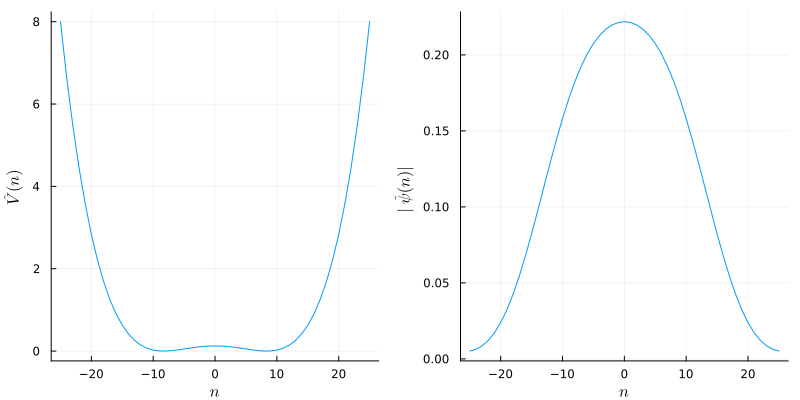

Energy: 2.93311e-01 ± 7.45058e-09
Position: (2.91080e-10) ± (7.30623e+00)
Momentum: (-7.19522e-13) ± (7.07432e-02)
Half-space probability: 4.75396e-01
ΔxΔp: (0.51686655055347,)


In [69]:
#Plot 1D potential & ground state

N = 51
μ, ϵ = 1, 0.12 #cool plot: 1, 0.07

n = lattice(N,1)
E_min, ψ_min = ground_state((N,), μ, ϵ, 1e-10, 1000, 1e-11, 1000)

p_1 = plot(n, potential(μ, ϵ, n), label=nothing)
xlabel!(L"n"); ylabel!(L"\hat{V}\,(n)")
p_2 = plot(n, abs.(ψ_min), label=nothing)
xlabel!(L"n"); ylabel!(L"|\hat{\psi}\,(n)|")

p = plot(p_1, p_2, layout = (1,2), size = (800,400), left_margin = 3Plots.mm)
display(p)

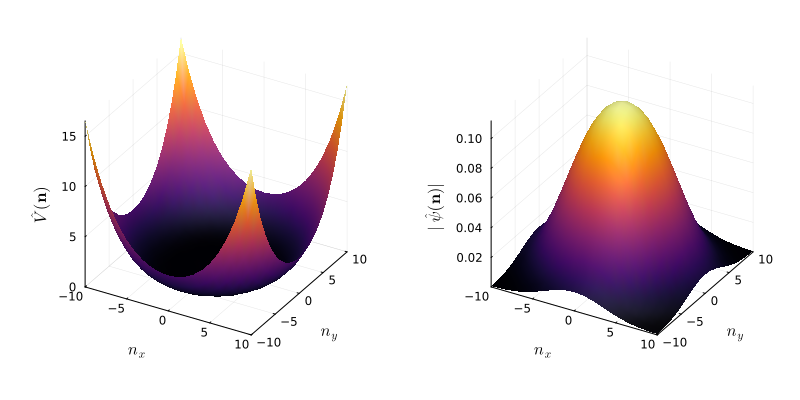

Energy: 5.63495e-01 ± 0.00000e+00
Position: (-1.47070e-10, -2.90275e-10) ± (3.25944e+00, 3.25944e+00)
Momentum: (-6.31319e-12, -7.07058e-12) ± (1.51671e-01, 1.51671e-01)
Half-space probability: 1.95298e-01
ΔxΔp: (0.4943627789505119, 0.4943627789500735)


In [71]:
#Plot 2D potential & ground state

N = 21
μ, ϵ = 1, 0.25 #cool plot: 1, 0.12

n_1D = lattice(N, 1)
n = lattice(N, 2)
E_min, ψ_min = ground_state((N,N), μ, ϵ, 1e-10, 1000, 1e-10, 1000)
ψ_min = ψ_min/norm(ψ_min)

p_1 = surface(n_1D, n_1D, potential(μ, ϵ, n), legend=nothing)
xlabel!(L"n_x"); ylabel!(L"n_y"); zlabel!(L"\hat{V}\,(\textbf{n})")
p_2 = surface(n_1D, n_1D, abs.(ψ_min), legend=nothing)
xlabel!(L"n_x"); ylabel!(L"n_y"); zlabel!(L"|\hat{\psi}\,(\textbf{n})|")

p = plot(p_1, p_2, layout = (1,2), size = (800,400))
display(p)